# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Agent Service

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
import os

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

The following cell will **create the Azure AI Agents**, so you only need to run this cell **once**.

In [3]:
# from common.create_azure_ai_agents import (
#     create_bing_search_agent,
#     create_research_plan_agent,
#     create_summary_agent,
#     create_research_report_agent,
#     create_peer_review_agent
# )

# planner_agent = create_research_plan_agent(project_client=project_client)
# bing_search_agent = create_bing_search_agent(project_client=project_client)
# summary_agent = create_summary_agent(project_client=project_client)
# research_agent = create_research_report_agent(project_client=project_client)
# peer_review_agent = create_peer_review_agent(project_client=project_client)

Fetch agents from your AI Foundry Project

In [4]:
planner_agent = project_client.agents.get_agent(agent_id=os.getenv("PlannerAgentID"))
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("BingSearchAgentID"))
summary_agent = project_client.agents.get_agent(agent_id=os.getenv("SummaryAgentID"))
research_agent = project_client.agents.get_agent(agent_id=os.getenv("ResearchAgentID"))
peer_review_agent = project_client.agents.get_agent(agent_id=os.getenv("PeerReviewAgentID"))

Update their system messages

In [5]:
from common.update_instructions import (
    update_planner_instructions,
    update_bing_instructions,
    update_summary_instructions,
    update_research_instructions,
    update_peer_review_instructions
)

planner_agent = update_planner_instructions(agent=planner_agent)
bing_search_agent = update_bing_instructions(agent=bing_search_agent)
summary_agent = update_summary_instructions(agent=summary_agent)
research_agent = update_research_instructions(agent=research_agent)
peer_review_agent = update_peer_review_instructions(agent=peer_review_agent)

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

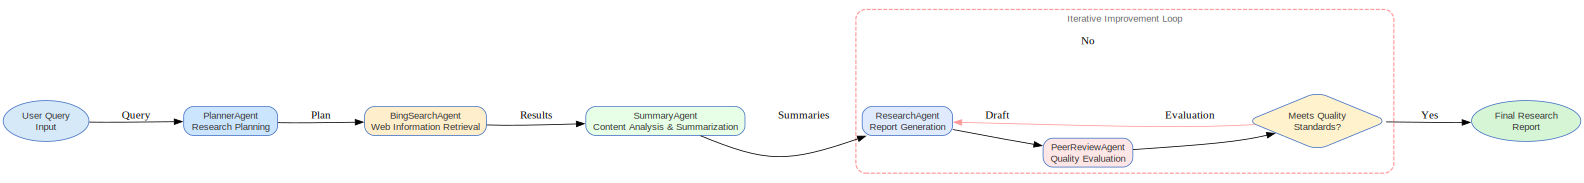

In [6]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [7]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [8]:
from azure.ai.agents.models import MessageRole
from common.data_models import ResearchPlan
from common.utils_ai_agents import (
    add_user_message_to_thread,
    invoke_agent
)
import json

# create a thread and add the user message
thread = project_client.agents.threads.create()
add_user_message_to_thread(project_client, thread.id, user_query)

# invoke the planner agent to create a research plan
planner_agent_output, thread = invoke_agent(
    project_client=project_client,
    thread=thread,
    agent=planner_agent
)

# parse the output to a ResearchPlan object
plan_data = json.loads(planner_agent_output)
plan = ResearchPlan(**plan_data)

# delete the thread
project_client.agents.threads.delete(thread_id=thread.id)

In [25]:
plan.research_tasks[0].search_queries

['What is classical machine learning?',
 'Definition of deep learning in AI',
 'What is generative AI?',
 'Foundational principles of classical machine learning, deep learning, and generative AI',
 'Comparison of classical ML, deep learning, and generative AI definitions']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict
from typing import Dict, Any, List, Tuple
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

MAX_WORKERS = 8  # adjust for your rate limits

def run_one_query(subtopic_name: str, query: str) -> Dict[str, Any]:
    prompt = f"""
    Research the following query: {query}
    This is related to subtopic: {subtopic_name}
    Please provide the information and cite your sources using the available tools.
    """
    thread = None
    try:
        thread = project_client.agents.threads.create()
        add_user_message_to_thread(project_client, thread.id, prompt)

        _out, _ = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=bing_search_agent
        )

        text, urls = extract_agent_response_and_urls(project_client, thread.id, query)
        return {"query": query, "agent_response": text, "results": urls}
    except Exception as e:
        return {"query": query, "results": [], "error": str(e)}
    finally:
        try:
            if thread is not None:
                project_client.agents.threads.delete(thread_id=thread.id)
        except Exception:
            pass

# Flatten tasks
# si: index of the subtopic
# qi: index of the query within that subtopic
# st.subtopic: the subtopic name
# q: the query text

tasks: List[Tuple[int, int, str, str]] = [
    (si, qi, st.subtopic, q)
    for si, st in enumerate(plan.research_tasks)
    for qi, q in enumerate(st.search_queries)
]

# Run in parallel
results = defaultdict(dict)  # results[si][qi] = entry
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    fmap = {ex.submit(run_one_query, subtopic_name, query): (si, qi)
            for si, qi, subtopic_name, query in tasks}
    for fut in tqdm(as_completed(fmap), total=len(fmap), desc="Running research queries in parallel"):
        si, qi = fmap[fut]
        try:
            results[si][qi] = fut.result()
        except Exception as e:
            results[si][qi] = {"query": tasks[si][3], "results": [], "error": str(e)}

# Rebuild in original shape and order
search_results: List[Dict[str, Any]] = []
for si, st in enumerate(plan.research_tasks):
    queries = [results[si].get(qi, {"query": q, "results": [], "error": "Missing result"})
               for qi, q in enumerate(st.search_queries)]
    search_results.append({"subtopic": st.subtopic, "queries": queries})

# Quick status
for block in search_results:
    ok = sum(1 for q in block["queries"] if "error" not in q)
    print(f"{block['subtopic']}: {ok}/{len(block['queries'])} queries succeeded")


Running research queries in parallel: 100%|██████████| 25/25 [01:02<00:00,  2.48s/it]

Definitions and foundational concepts: 5/5 queries succeeded
Methodologies and underlying architectures: 5/5 queries succeeded
Application domains and use cases: 5/5 queries succeeded
Strengths, limitations, and challenges: 5/5 queries succeeded
Future trends and ongoing research: 5/5 queries succeeded


In [27]:
print(f"Planned total search queries: {sum(1 for task in plan.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 25

Actually total search queries: 25



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, Any, List, Tuple
from tqdm import tqdm
from common.utils_summary import collect_responses_and_citations

MAX_WORKERS_SUMMARY = 5

def summarize_one(subtopic_result: Dict[str, Any]) -> Dict[str, Any]:
    all_responses, unique_citations = collect_responses_and_citations(subtopic_result)
    content = "\n\n---\n\n".join(all_responses)

    summary = "No content found to summarize for this subtopic."
    thread = None
    if content:
        summary_prompt = (
            f"Summarize the following information related to the subtopic "
            f"'{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content}"
        )
        try:
            thread = project_client.agents.threads.create()
            add_user_message_to_thread(project_client, thread.id, summary_prompt)
            out, _ = invoke_agent(project_client=project_client, thread=thread, agent=summary_agent)
            summary = out.strip()
        except Exception as e:
            sub = subtopic_result.get('subtopic', 'Unknown Subtopic')
            summary = f"Error during summarization for subtopic '{sub}'. Details: {e}"
        finally:
            try:
                if thread is not None:
                    project_client.agents.threads.delete(thread_id=thread.id)
            except Exception:
                pass

    citations_list = [{"title": t, "url": u} for (t, u) in unique_citations]
    return {
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"),
        "summary": summary,
        "citations": citations_list,
    }

# Run all subtopics in parallel and preserve order
mapped_chunks: List[Dict[str, Any]] = [None] * len(search_results)

with ThreadPoolExecutor(max_workers=MAX_WORKERS_SUMMARY) as ex:
    fmap = {ex.submit(summarize_one, subtopic_result): i
            for i, subtopic_result in enumerate(search_results)}
    for fut in tqdm(as_completed(fmap), total=len(fmap), desc="Summarizing subtopics in parallel"):
        i = fmap[fut]
        try:
            mapped_chunks[i] = fut.result()
        except Exception as e:
            sub = search_results[i].get("subtopic", "Unknown Subtopic")
            mapped_chunks[i] = {
                "subtopic": sub,
                "summary": f"Error during summarization for subtopic '{sub}'. Details: {e}",
                "citations": [],
            }

# Optional: quick status
ok = sum(1 for m in mapped_chunks if m and not m["summary"].startswith("Error during summarization"))
print(f"Summaries completed: {ok}/{len(mapped_chunks)}")


Summarizing subtopics in parallel: 100%|██████████| 5/5 [01:37<00:00, 19.57s/it]

Summaries completed: 5/5


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [1]:
def print_thread_messages(thread):
    messages = project_client.agents.messages.list(thread_id=thread.id)
    for m in messages:
        print(f"roll: {m.role}")
        print(f"agent_id: {m.agent_id}")
        print(f"content: {m.content[0]['text']['value']}")
        print("---")

In [2]:
from common.data_models import ComprehensiveResearchReport, PeerReviewFeedback
from common.utils_ai_agents import add_user_message_to_thread

def loop_agents(project_client, agent_a, agent_b, initial_input, max_iterations=10):
    """
    Loop between two agents until agent B produces the target output.
    
    Args:
        agent_a: Function that takes input and returns output
        agent_b: Function that takes input and returns output
        initial_input: Starting input for agent A
        max_iterations: Safety limit to prevent infinite loops
    
    Returns:
        The final output from agent B, or None if max iterations reached
    """
    current_input = initial_input
    thread = project_client.agents.threads.create()
    add_user_message_to_thread(project_client, thread.id, current_input)

    for i in range(max_iterations):
        # Agent A processes the input and produces output
        a_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_a
        )

        handover_message = f"A research agent has produced a research report. Please review it."
        add_user_message_to_thread(project_client, thread.id, handover_message)
        
        # Agent B reviews the output
        b_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_b
        )

        b_output_json = json.loads(b_output)
        review = PeerReviewFeedback(**b_output_json)

        # Check if B produced the target output
        if review.is_satisfactory is not False:
            print(f"Target output reached after {i+1} iterations!")
            report_json = json.loads(a_output)
            final_report = ComprehensiveResearchReport(**report_json)

            # delete the thread
            # print_thread_messages(thread)
            project_client.agents.threads.delete(thread_id=thread.id)
            return final_report
        
        # Use B's output as input for the next iteration
        current_input = b_output
        
        handover_message = f"Peer review agent has provided feedback. Please revise the research report based on the feedback."
        add_user_message_to_thread(project_client, thread.id, handover_message)

    # delete the thread
    # print_thread_messages(thread)
    project_client.agents.threads.delete(thread_id=thread.id)
    print(f"Max iterations ({max_iterations}) reached without finding target output")

    return None

In [ ]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

research_query = (
    "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
    "using the following content. **Minimize bullet points** and ensure the final text resembles "
    "a cohesive, academic-style paper:\n\n"
    f"{research_input_prompt}\n\n"
    "As a final reminder, don't forget to include the citation list at the end of the report."
)

# Run the loop
final_report = loop_agents(
    project_client=project_client,
    agent_a=research_agent,
    agent_b=peer_review_agent,
    initial_input=research_query,
    max_iterations=10
)

In [ ]:
from IPython.display import display, Markdown
display(Markdown(final_report.research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI: Definitions, Methodologies, Applications, Strengths, Limitations, and Future Trends

## Introduction

The field of artificial intelligence (AI) has undergone rapid and transformative evolution over the past several decades, culminating in a diverse landscape of methodologies that underpin modern intelligent systems. Among the most influential paradigms are classical machine learning (ML), deep learning (DL), and generative AI (GenAI), each representing a distinct phase in the progression of computational intelligence. These approaches have not only revolutionized how machines learn from data but have also expanded the boundaries of what is possible in terms of prediction, classification, and content generation. This report provides a comprehensive, authoritative comparison and contrast of classical machine learning, deep learning, and generative AI, with an emphasis on their definitions, foundational concepts, methodologies, application domains, strengths, limitations, and future trends. By synthesizing insights from academic literature, industry reports, and recent research, the analysis aims to clarify the nuanced distinctions and interconnections among these paradigms, offering a detailed perspective for practitioners, researchers, and decision-makers.

## Definitions and Foundational Concepts

Understanding the landscape of AI begins with clear definitions and a grasp of the foundational concepts that differentiate classical machine learning, deep learning, and generative AI. These three pillars form a continuum, each building upon the principles of its predecessor while extending the capabilities of intelligent systems.

### Classical Machine Learning

Classical machine learning encompasses a set of algorithms and statistical models designed to enable computers to learn patterns from structured data and make predictions or decisions without explicit programming for each task. The primary modalities within classical ML include supervised learning, unsupervised learning, and reinforcement learning. Supervised learning involves training models on labeled datasets, where each input is paired with a known output, facilitating tasks such as regression (predicting continuous values) and classification (assigning categorical labels). Common algorithms include linear regression, logistic regression, decision trees, support vector machines, and k-nearest neighbors. Unsupervised learning, in contrast, seeks to uncover patterns or groupings in unlabeled data, employing techniques like k-means clustering and principal component analysis (PCA) to discover underlying structures. Reinforcement learning extends the paradigm by enabling agents to interact with environments, learning optimal actions through trial and error to maximize cumulative rewards—a technique widely used in robotics and game AI[1][2].

Foundational principles in classical ML include overfitting (where models memorize training data noise at the expense of generalization), the bias-variance trade-off (balancing model simplicity and flexibility), and model evaluation metrics such as accuracy, precision, recall, and F1-score. Feature engineering is a hallmark of classical ML, requiring manual extraction and selection of relevant information from raw data—a process that demands domain expertise and careful consideration. Classical ML methods are most effective with small-to-medium-sized, structured datasets, and their interpretability makes them suitable for domains where transparency and explainability are paramount[3][4].

### Deep Learning

Deep learning is a specialized subset of machine learning that leverages multi-layered artificial neural networks to automatically learn complex, hierarchical representations from large volumes of unstructured data. Inspired by the architecture of the human brain, deep learning models such as convolutional neural networks (CNNs), recurrent neural networks (RNNs), and transformers have demonstrated remarkable success in tasks like computer vision, natural language processing, and autonomous decision-making. The training process typically involves backpropagation, where an error signal derived from a loss function is propagated through the network to adjust weights using gradient descent optimization techniques[5][6].

Deep learning’s capacity for generalizability allows models to excel in domains where classical ML struggles, particularly with high-dimensional data such as images, audio, and text. The automatic feature extraction capability of deep neural networks obviates the need for manual feature engineering, enabling the discovery of intricate patterns and relationships within data. However, the over-parameterization characteristic of deep models presents both advantages (increased flexibility and expressivity) and challenges (tendency to overfit, need for regularization). Ethical concerns, including privacy, robustness to adversarial attacks, and the opacity of decision processes, are prominent in deep learning research[7][8].

### Generative AI

Generative AI represents a further evolution in the AI landscape, employing deep learning architectures to create entirely new data and content—text, images, audio, code—by modeling and sampling from the statistical distributions of training datasets. Unlike traditional models focused on classification or prediction, generative AI systems learn the underlying statistical patterns of training data and synthesize outputs that capture the style and structure of the originals without being exact replicas. Foundational generative models include Generative Adversarial Networks (GANs), which use a two-network adversarial process to create realistic outputs; Variational Autoencoders (VAEs), which compress and reconstruct data to enable sample generation; and transformer-based large language models (LLMs) like GPT and BERT, which capture long-range dependencies in sequential data for tasks ranging from chatbot dialogues to text-to-image synthesis[9][10].

Generative AI differs fundamentally from discriminative models by enabling creative and productive AI applications, such as generating artworks, composing music, writing prose, or producing synthetic data for research. The field has experienced explosive growth since the 2020s, driven by advances in deep learning architectures and the availability of ever-larger datasets. GenAI’s multi-modality allows for seamless interaction with text, image, audio, and code data, transforming industries from entertainment to healthcare. However, it also raises urgent ethical and societal questions, including authenticity, bias propagation, and responsible use[11][12].

### Shared Foundational Principles

Across all three domains, shared foundational principles inform practice and application. Model evaluation, feature selection, and a grounding in probability and statistics are essential for robust AI system development. The evolution from classical ML to DL to GenAI marks a transition from manual, human-guided learning to automated, highly flexible, and creative machine intelligence. Ethical considerations, such as bias, authenticity, and privacy, are increasingly central to the responsible deployment of AI technologies[13][14].

### Timeline of Major Developments

| Year | Classical ML | Deep Learning | Generative AI |
|------|--------------|--------------|--------------|
| 1950s-1970s | Linear regression, decision trees | Perceptron (single-layer neural nets) | - |
| 1980s | SVM, k-means, PCA | Backpropagation, early multi-layer nets | - |
| 1990s | Ensemble methods, random forests | CNNs for digit recognition | - |
| 2006 | - | Deep belief networks | - |
| 2012 | - | AlexNet (ImageNet breakthrough) | - |
| 2014 | - | - | GANs introduced |
| 2017 | - | Transformer architecture | - |
| 2018-2020 | - | BERT, GPT-2 | VAEs, LLMs |
| 2021-2024 | - | EfficientNet, multimodal transformers | DALL-E, Stable Diffusion, Sora |

## Methodologies and Underlying Architectures

The methodologies and underlying architectures of classical machine learning, deep learning, and generative AI are distinguished by their data requirements, architectural complexity, and approach to feature learning or content generation. A comparative analysis reveals that the choice of architecture and methodology is dependent on the application domain, data type, and desired outcome—whether prediction, classification, or generation.

### Classical Machine Learning Methodologies

Classical machine learning relies on interpretable, shallow models with explicit feature engineering. Supervised learning algorithms such as linear regression, logistic regression, support vector machines, and decision trees map inputs directly to outputs, optimizing loss functions to minimize prediction errors. Unsupervised learning techniques like k-means clustering and PCA focus on discovering patterns and reducing dimensionality in unlabeled data. Reinforcement learning agents interact with environments, learning optimal policies through reward maximization. Model training in classical ML emphasizes regularization, cross-validation, and pruning to prevent overfitting and ensure generalizability[15][16].

Architecturally, classical ML models are shallow, with limited layers and parameters, facilitating transparency and ease of interpretation. Feature engineering is a critical step, requiring domain expertise to extract meaningful variables from raw data. Classical neural network architectures, such as feed-forward networks with standard activation functions (Sigmoid, ReLU), are included but remain limited in expressivity compared to deep networks. Specialized models like wavelet neural networks and extreme learning machines enhance feature extraction and accelerate training, but their adoption is niche and context-dependent[17][18].

### Deep Learning Architectures

Deep learning marks a paradigm shift by employing deep neural networks with many layers capable of autonomously learning hierarchical representations. Convolutional Neural Networks (CNNs) are the backbone for spatial data, leveraging convolutional and pooling layers for effective feature abstraction and dimensionality reduction. Recurrent Neural Networks (RNNs) specialize in sequential and temporal data, maintaining context through hidden states; variants such as Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU) address long-term dependency issues, crucial in text and speech applications. Transformers, utilizing self-attention mechanisms, revolutionize sequence data processing by enabling parallel computation and modeling complex dependencies without recurrence[19][20].

Deep learning architectures are highly data- and computation-intensive, but their automatic feature learning capabilities bypass the need for manual engineering, making them suitable for image classification, natural language processing, and speech recognition tasks. Training involves backpropagation and gradient descent, with regularization techniques such as dropout, batch normalization, and data augmentation employed to mitigate overfitting and enhance generalization. The scalability and flexibility of deep learning models have driven breakthroughs in domains previously inaccessible to classical ML[21][22].

### Generative AI Methodologies

Generative AI advances methodologies by shifting focus from prediction to novel content creation. Core underlying architectures include Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), Diffusion Models, and Large Language Models (LLMs). GANs operate as a two-player adversarial system, where a generator crafts synthetic data from noise and a discriminator judges authenticity. Training is a competitive minimax game that drives the generator to produce increasingly realistic outputs. GANs excel in high-fidelity image synthesis but require careful stabilization and are prone to mode collapse (limited output diversity)[23][24].

VAEs utilize an encoder-decoder framework, compressing data into a latent probabilistic space and reconstructing it, optimizing both reconstruction loss and KL divergence to ensure sample diversity. VAEs favor exploration of latent space and diverse output generation but often trade off sample sharpness for generativity. Diffusion models iteratively refine noisy inputs, learning to reverse incremental noise addition to generate high-quality samples. While diffusion models produce superior diversity and fidelity, their multi-step generation makes them computationally slower. LLMs like GPT, built on transformer architectures, dominate text generation tasks, learning complex semantic and syntactic structures from vast corpora[25][26].

Comparative analyses across these paradigms reveal trade-offs tailored to data modality, task requirements, and computational constraints. Classical ML is favored for interpretability and efficiency in structured environments, deep learning for unstructured, large-scale data and hierarchical feature learning, and generative AI for content creation where fidelity, diversity, and realism are critical. The evolution from shallow to deep to generative architectures reflects increasing abstraction, expressivity, and capability, with ongoing research focused on improving interpretability, efficiency, and domain adaptation[27][28].

### Comparison Table: Methodological and Architectural Differences

| Aspect | Classical ML | Deep Learning | Generative AI |
|--------|--------------|--------------|--------------|
| Data Type | Structured/tabular | Unstructured (images, text, audio) | Unstructured/multimodal |
| Feature Engineering | Manual | Automated | Automated |
| Model Depth | Shallow | Deep (multi-layered) | Deep, often with adversarial or probabilistic components |
| Interpretability | High | Low to moderate | Low |
| Computational Needs | Low to moderate | High | Very high |
| Output | Predictions, classifications | Predictions, classifications | Novel content generation |
| Example Algorithms | SVM, decision trees, k-means | CNN, RNN, transformers | GAN, VAE, diffusion models, LLMs |

## Application Domains and Use Cases

The application domains and use cases for classical machine learning, deep learning, and generative AI reveal the distinctive strengths and transformative effects of each technology across multiple industries. Their impact is a function of the nature of the data (structured/tabular vs. unstructured), the complexity of the task, and specific industry needs.

### Classical Machine Learning Applications

Classical machine learning finds its core utility in scenarios where data is structured and interpretability, speed, and reliability are essential. In healthcare, classical ML models such as decision trees and logistic regression are widely used for disease detection (e.g., cancer or Parkinson’s) from structured data, predictive risk modeling, and streamlining drug discovery pipelines by predicting compound interactions. In finance and banking, ML underpins cornerstone applications such as fraud detection, credit scoring, and stock market forecasting by identifying patterns and anomalies in tabular transaction data. Retail and e-commerce benefit from ML-driven recommendation systems (such as Amazon and Netflix’s product/content suggestions), personalized marketing campaigns, inventory management, and churn prediction. Other sectors like manufacturing (predictive maintenance and quality assurance), agriculture (crop yield, pest detection), business intelligence (demand forecasting, supply chain analysis), and cybersecurity (anomaly, spam filtering) also rely heavily on classical ML approaches. These models typically require manual feature engineering, have lower data requirements, and offer interpretability crucial for compliance or stakeholder trust[29][30].

### Deep Learning Applications

Deep learning expands far beyond the capabilities of classical ML by harnessing convolutional neural networks, recurrent neural networks, and transformers to process vast amounts of unstructured data—images, text, audio—automatically extracting complex features for superior performance. In healthcare, deep learning powers medical imaging diagnostics, achieving dermatologist-level accuracy in cancer detection from pathology images, and accelerates drug discovery using large datasets to predict molecular interactions. Deep learning is fundamental in autonomous vehicles (self-driving cars), where computer vision and sensor fusion enable real-time object recognition and safe navigation. NLP applications leverage deep learning for virtual assistants (Siri, Alexa, Google Assistant), chatbots, automated summarization, and language translation, driving accessibility and productivity. In computer vision, deep learning models excel in image segmentation, facial and biometric recognition, and video analytics for security and retail. Financial institutions use deep learning for advanced fraud detection and market forecasting, while cybersecurity exploits it for more nuanced threat detection. Entertainment and media are transformed by deep learning's ability to play complex games, generate lifelike content and images, and automate content annotation[31][32].

### Generative AI Applications

Generative AI takes the possibilities of deep learning further, enabling creative automation and personalized experiences at scale. Powered by advanced architectures such as GANs, VAEs, and transformers (GPT, DALL-E, etc.), generative AI is redefining how content and data are produced and consumed across industries. In healthcare, it generates synthetic medical images for training, proposes novel drug molecules, and designs individualized therapy plans based on granular patient data. Finance uses generative models to simulate fraudulent transactions for training, create tailored investment advice, and automate document summarization. The manufacturing and automotive sectors leverage generative AI for rapid prototyping, vehicle design iterations (e.g., Toyota), and supply chain simulations. In software, tools like GitHub Copilot automate code generation and generate testing scenarios, revolutionizing development workflows. Media and entertainment industries utilize generative AI for creating scripts, music, art, and videos (using platforms like DALL-E and Sora), drastically reducing production timelines and amplifying creativity. Chatbots and virtual assistants are increasingly powered by generative AI for highly personalized customer service, automated summarization, and retention strategies. Marketing and advertising benefit from AI-generated copywriting and hyper-customized content to boost engagement and conversion rates. With the rapid proliferation of generative AI—over 70% adoption in businesses by 2024—its projected economic impact may reach trillions of dollars by 2030[33][34].

### Impact Assessment Matrix Across Industries

| Industry | Classical ML | Deep Learning | Generative AI |
|----------|--------------|--------------|--------------|
| Healthcare | Disease detection, risk modeling | Medical imaging, drug discovery | Synthetic images, personalized therapy |
| Finance | Fraud detection, credit scoring | Advanced fraud detection, forecasting | Simulated transactions, tailored advice |
| Retail/E-commerce | Recommendations, inventory | Image analytics, customer insights | Personalized marketing, content creation |
| Manufacturing | Predictive maintenance | Quality assurance, robotics | Rapid prototyping, design iteration |
| Media/Entertainment | Churn prediction | Content annotation, image/video analytics | Script/music/art generation, video synthesis |
| Cybersecurity | Spam filtering, anomaly detection | Threat detection | Synthetic data for training, scenario simulation |

### Comparative Nuances and Industry Adoption Trends

The technologies exhibit nuanced differences in adoption and suitability. Classical ML remains indispensable for structured, interpretable, low-latency tasks and foundational predictive models. Deep learning excels in high-volume, unstructured data applications, automating complex feature learning for tasks where precision and scalability matter. Generative AI, built atop deep learning, is uniquely positioned for creative generation, synthetic data creation, and advanced conversational tasks (e.g., retrieval augmented generation—RAG—for enterprise chatbots and business intelligence). Key industry adoption drivers include data type, explainability, cost, computational resources, and the requirement for creativity or simulation. Deep learning’s automation of feature extraction contrasts with classical ML’s manual feature engineering, while generative AI’s novelty lies in generating entirely new data, content, or scenarios—essential for personalization and democratizing complex tasks[35][36].

## Strengths, Limitations, and Challenges

A nuanced understanding of the strengths, limitations, and challenges of classical machine learning, deep learning, and generative AI is essential for informed deployment and responsible innovation. Each paradigm offers unique advantages and faces distinct obstacles, shaped by technical, operational, and ethical considerations.

### Classical Machine Learning

Classical machine learning boasts notable strengths in efficiency and cost-effectiveness, requiring less computational power and smaller datasets compared to modern AI methods. These algorithms effectively automate repetitive tasks and improve decision-making in predictive analytics, customer segmentation, and fraud detection. Their simplicity generally enables high levels of transparency and interpretability, making them preferable in domains like healthcare and finance where understanding the reasoning behind predictions is paramount. Classical ML algorithms also support scalability and continuous improvement as more data becomes available[37][38].

However, their limitations stem largely from dependence on high-quality, labeled data, manual feature engineering—necessitating significant domain expertise—and challenges in generalizing to unseen scenarios. Classical ML underperforms in tasks involving unstructured or complex data, where the inability to capture hierarchical patterns constrains performance. Issues of overfitting and underfitting persist if model and data selection are not judiciously handled. These methods, while easier to audit, may still propagate biases depending on data representativeness and feature selection, and can struggle to explain decisions in high-dimensional contexts[39][40].

### Deep Learning

Deep learning, leveraging neural architectures such as CNNs, RNNs, LSTMs, and Transformers, has driven exceptional progress in computer vision, speech recognition, and natural language processing through its capacity for automatic hierarchical feature extraction. These models excel at pattern recognition in high-dimensional, unstructured datasets, often achieving state-of-the-art performance. The scalability of deep learning allows deployment on vast datasets, increasing the breadth and depth of applications[41][42].

Nonetheless, deep learning models are highly data-dependent, requiring enormous, high-quality, labeled datasets for optimal performance—a barrier compounded by the high costs of data collection, annotation, and privacy concerns. Deep learning architectures are computationally intensive, necessitating specialized hardware (GPUs/TPUs), which elevates resource consumption and environmental impact. The opaque "black box" nature of DL models impedes explainability, which is critical in regulated sectors; ongoing research in explainable AI is addressing but has not resolved these issues. Persistent risks include the amplification of biases in data, susceptibility to overfitting with limited data or excessive complexity, lengthy training times (potentially spanning days/weeks), and exposures to adversarial attacks that compromise reliability and security[43][44].

### Generative AI

Generative AI systems (e.g., GPT, DALL-E, Stable Diffusion) have redefined content creation, enabling the generation of novel text, images, music, and code with striking human-like fluency and creativity. Strengths of generative AI include rapid automation of design, research acceleration via synthetic data creation, and enhancement of productivity and customer experiences through intelligent assistants. These capabilities facilitate novel interactions, data augmentation, and simulation, with broad utility in industries ranging from media to medicine[45][46].

However, generative AI is beset by pronounced limitations and challenges. Models demand vast, diverse, and high-quality training data; when sourced from heterogeneous, incomplete, or biased datasets, outputs risk unreliability, contradiction, and harm to trust. Privacy risks escalate as sensitive information may leak through memorization or inadvertent inclusion. Bias and fairness concerns are acute—training data biases can propagate and exacerbate societal inequalities, damaging reputation and inclusivity. Security threats emerge from adversarial data poisoning, creating backdoors or malicious behavior, increasing risk especially for supply-chain or third-party model deployments[47][48].

Intellectual property infringement—when outputs resemble existing works—triggers legal complexity. Operationally, scaling generative models within enterprise environments challenges legacy integration, model reliability, and cost-effectiveness (owing to substantial computational requirements). Regulatory and ethical compliance remains uncertain, as frameworks like GDPR and HIPAA seek to mitigate misuse, misalignment, and accountability gaps. The shortage of technically and ethically skilled talent further restrains responsible deployment. Unique risks—such as misinformation and deepfakes—directly threaten trust, safety, and even democratic values, while output "hallucinations" pose practical dangers in critical decision contexts. The alignment and control of generative models to human values is still an unsolved research frontier, demanding multidisciplinary scrutiny and continuous improvement[49][50].

### Comparative Perspective

The strengths and challenges of each paradigm are context-dependent. Classical ML offers transparency and efficiency for well-defined tasks on structured data but is outpaced by DL and generative AI in complex, unstructured domains. Deep learning delivers automated feature extraction and superior performance on burgeoning datasets but at the cost of resource intensity and interpretability. Generative AI achieves creative automation and augmentation but poses acute ethical, security, and operational challenges, requiring new policies, frameworks, and ongoing dialogue to address societal impacts. Shared across all technologies are issues of bias, fairness, data quality, and generalization—each requiring deliberate attention. Technical scalability, interpretability, operational cost, and susceptibility to misuse mark the dividing lines. As AI evolves, responsible innovation demands transparent guidelines, interdisciplinary approaches, and frameworks for accountable deployment to balance performance, trust, and societal benefit[51][52].

### Hierarchical Breakdown of Challenges

| Challenge | Classical ML | Deep Learning | Generative AI |
|-----------|-------------|--------------|--------------|
| Interpretability | High | Low | Low |
| Data Requirements | Moderate | High | Very high |
| Computational Cost | Low | High | Very high |
| Bias/Fairness | Moderate | High | Very high |
| Security | Moderate | High | Very high |
| Explainability | High | Low | Low |
| Scalability | High | High | Moderate |
| Ethical/Legal | Moderate | High | Very high |

## Future Trends and Ongoing Research

As of 2025, the future of machine learning, deep learning, and generative AI is defined by several converging trends and active research areas. Significant advancements in edge AI and on-device learning now allow models to operate efficiently on platforms like smartphones, wearables, and industrial IoT sensors. Utilizing techniques such as model compression, quantization, and pruning, these systems deliver analytics with reduced latency and improved privacy, critical for sectors like healthcare, smart homes, and factories. Edge deployment also supports real-time decision-making and circumvents the bandwidth, privacy, and regulatory challenges posed by cloud reliance[53][54].

A pivotal shift in research is the data-centric paradigm: Instead of pursuing incremental improvements in model architecture alone, researchers focus on improving data quality, privacy, and representation. Automated dataset curation, active learning, and synthetic data generation—leveraging generative adversarial networks and diffusion models—tackle the issues of scarce or biased data. Practices such as data versioning and lineage tracking now underpin robust ML workflows[55][56].

With AI adoption surging in regulated industries, the call for explainable and responsible AI has never been louder. Interpretability tools like SHAP and Integrated Gradients, coupled with causal inference frameworks, help demystify predictions and enforce fairness. Regulatory measures, notably the EU AI Act, accelerate mainstream uptake of responsible and ethical AI practices. Ensuring accountability and minimizing bias are now integral not just to classical ML, but also in deployment of autonomous systems and deep learning models[57][58].

Continual learning and online learning are fostering adaptive models that thrive in dynamic environments, ingesting streaming data and updating themselves to reflect new patterns. Methods like Elastic Weight Consolidation and meta-learning mitigate catastrophic forgetting and enhance robustness, essential for systems exposed to non-stationary data[59][60].

Quantum computing emerges as an aspirational yet active future direction, with quantum machine learning algorithms promising exponentially faster problem-solving in optimization, cryptography, and simulation. Though still in exploratory phases, integration of quantum neural networks and hybrid quantum-classical architectures could redefine computational boundaries[61][62].

Foundation models and multimodal learning are reshaping both classical ML and deep learning. Pre-trained, large-scale models (like LLMs and multimodal transformers) can be fine-tuned efficiently using parameter-efficient strategies and quantization-aware training. This trend enables unified handling of text, images, audio, and video, fostering richer and more context-aware solutions[63][64].

Autonomy takes center stage with agentic systems—AI that acts as operational partners rather than mere assistive tools. These agentic systems autonomously execute tasks, plan actions, and interact with digital infrastructure (APIs, databases), revolutionizing fields such as customer support, logistics, and personal assistant technologies[65][66].

To address privacy and ethical imperatives, federated learning and differential privacy techniques are widely adopted. By training models across decentralized devices while keeping raw data local, these approaches offer robust privacy and security. Healthcare, finance, and other sensitive sectors are at the forefront of federated ML adoption[67][68].

Environmental sustainability and energy efficiency are no longer peripheral concerns. Research prioritizes developing greener algorithms, reducing computational and training costs, and designing energy-conserving hardware—aligning with scalable deployment needs and global climate goals[69][70].

The hyper-personalization movement, fueled by sophisticated recommendation systems and integrative analysis of cross-domain data, is delivering tailored experiences at scale. Generative AI extends this capability, driving bespoke marketing, individualized healthcare, and adaptive education tools[71][72].

Deep learning research focuses on several overlapping directions:
- Explainable AI (XAI): Improving trust and accountability, especially in sensitive applications (healthcare, autonomous vehicles).
- Self-supervised and transfer learning: Leveraging unlabeled and pre-trained data to make deep learning more accessible, efficient, and adaptive.
- Quantum enhancements and edge deployment: Advancing toward quantum neural networks and resource-efficient inference on portable devices.
- Open-source ecosystems: Democratizing access to state-of-the-art models and fostering innovation through collaborative research[73][74].

Generative AI continues its meteoric rise, with democratization efforts bringing advanced tools to non-technical users and industries. By 2025, the U.S. alone is projected to invest over $67 million in generative AI integration. The creative sector anticipates market growth from $1.7 billion in 2022 to $21.6 billion by 2032. Generative models are becoming more efficient and reliable, transitioning focus from raw model size to capability, dependability, and energy usage[75][76].

A prominent challenge remains the reduction of hallucinations—AI-generated inaccuracies or fabricated information. Solutions like retrieval-augmented generation (RAG), benchmarks (RGB, RAGTruth), and engineering-based approaches are systematically decreasing such occurrences. Simultaneously, agentic AI is making strides in autonomous decision-making, with 78% of executives foreseeing the need to design digital ecosystems tailored for AI agents in the near future[77][78].

Enterprises are prioritizing ethical governance, scalable reliability, and responsible deployment, shifting from experimental pilots to full integration of generative and agentic AI. The open-source community continues to accelerate these advancements by sharing tools, datasets, and benchmarks globally.

Interdisciplinary integration is a cross-cutting trend: Machine learning intersects with domains like scientific discovery, climate modeling, financial analytics, medical diagnostics, robotics, and environmental monitoring, furthering societal impact. Hybrid and ensemble approaches—blending classical, deep, and generative ML—yield more robust and comprehensive AI systems[79][80].

In conclusion, ongoing research and future trends in classical machine learning, deep learning, and generative AI revolve around efficiency, adaptability, explainability, ethics, sustainability, and integration with emerging technologies. These developments are poised to profoundly influence various industries, elevate AI’s societal role, and stimulate continued scientific innovation. The rapid evolution in these domains underscores the importance for practitioners, enterprises, and regulators to stay abreast of new findings, technical standards, and ethical best practices.

## Conclusion

The comparative analysis of classical machine learning, deep learning, and generative AI reveals a rich tapestry of methodologies, applications, strengths, limitations, and future directions. Classical ML remains foundational for structured data tasks requiring transparency and efficiency, while deep learning has unlocked the potential of unstructured data through automated feature extraction and hierarchical modeling. Generative AI, built atop deep learning, is redefining creativity, personalization, and automation, but introduces complex challenges in ethics, security, and reliability. The interplay among these paradigms is driving convergence, hybridization, and interdisciplinary innovation, ensuring that AI continues to evolve as a transformative force across industries and society. As research advances and adoption accelerates, the responsible deployment of AI technologies will hinge on balancing performance, trust, and societal benefit, guided by transparent frameworks and ongoing dialogue among stakeholders.

## References

[1] The 2025 Guide to Machine Learning - IBM, https://www.ibm.com/think/machine-learning
[2] Classical Machine Learning Principles and Methods, https://link.springer.com/chapter/10.1007/978-1-4842-8692-0_1
[3] What Are Machine Learning Concepts? - Coursera, https://www.coursera.org/articles/machine-learning-concepts
[4] Overview of Machine Learning Part 1: Fundamentals and Classic ..., https://www.sciencedirect.com/science/article/pii/S1052514920300629
[5] Deep learning - Wikipedia, https://en.wikipedia.org/wiki/Deep_learning
[6] What Is Deep Learning? | Microsoft Azure, https://azure.microsoft.com/en-us/resources/cloud-computing-dictionary/what-is-deep-learning/
[7] What is deep learning? - IBM, https://www.ibm.com/think/topics/deep-learning
[8] Deep Learning: Foundations and Concepts: by Christopher M. Bishop and ..., https://www.tandfonline.com/doi/pdf/10.1080/14697688.2024.2436137
[9] Generative artificial intelligence - Wikipedia, https://en.wikipedia.org/wiki/Generative_artificial_intelligence
[10] Roadmap to Generative AI: A Comprehensive Guide for Beginners, https://www.geeksforgeeks.org/artificial-intelligence/roadmap-to-generative-ai-a-comprehensive-guide-for-beginners/
[11] What is Generative AI (GenAI)? Definition, How It Works, Applications ..., https://www.sciencenewstoday.org/what-is-generative-ai-genai-definition-how-it-works-applications-and-future-impact
[12] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[13] AI vs ML vs DL vs GenAI: Key Differences Explained - FS.com, https://www.fs.com/blog/artificial-intelligence-vs-machine-learning-vs-deep-learning-vs-generative-ai-key-differences-explained-24134.html
[14] Fundamentals of Machine Learning and Artificial Intelligence, https://www.coursera.org/learn/fundamentals-of-machine-learning-and-artificial-intelligence
[15] Classical Machine Learning Algorithms | SpringerLink, https://link.springer.com/chapter/10.1007/978-981-96-2621-2_3
[16] Chapter 2 Classic Machine Learning Methods, https://johannfaouzi.github.io/media/publications/mlbd_chapter2.pdf
[17] [2310.11470] Classic machine learning methods - arXiv.org, https://arxiv.org/abs/2310.11470
[18] Core Concepts of Machine Learning (classical) | GRAUSOFT, https://grausoft.net/core-concepts-of-machine-learning/
[19] Deep Learning Architectures From CNN, RNN, GAN, and Transformers To ..., https://www.marktechpost.com/2024/04/12/deep-learning-architectures-from-cnn-rnn-gan-and-transformers-to-encoder-decoder-architectures/
[20] Comparative Analysis of CNN, RNN, LSTM, and Transformer Architectures ..., https://kuey.net/index.php/kuey/article/download/10364/7966/19317
[21] Optimizing deep learning predictive models: A ... - ScienceDirect, https://www.sciencedirect.com/science/article/pii/S1568494625013286
[22] Deep Learning: Foundations and Concepts - Microsoft Research, https://www.microsoft.com/en-us/research/publication/deep-learning-foundations-and-concepts/
[23] Generative Models in AI: A Comprehensive Comparison of GANs and VAEs ..., https://www.geeksforgeeks.org/deep-learning/generative-models-in-ai-a-comprehensive-comparison-of-gans-and-vaes/
[24] Generative Models - Architectures and Applications of GANs, VAEs, and ..., https://www.techrxiv.org/users/806772/articles/1325610-generative-models-architectures-and-applications-of-gans-vaes-and-diffusion-models
[25] Comparing Diffusion, GAN, and VAE Techniques - Generative AI Lab, https://generativeailab.org/l/generative-ai/a-tale-of-three-generative-models-comparing-diffusion-gan-and-vae-techniques/569/
[26] Synthetic Scientific Image Generation with VAE, GAN, and Diffusion ..., https://www.mdpi.com/2313-433X/11/8/252
[27] Understanding Generative AI, Machine Learning, and Deep Learning, https://swirlaiconnect.com/understanding-generative-ai-machine-learning-and-deep-learning/
[28] AI vs ML vs Deep Learning vs GenAI — The Cloud Girl, https://www.thecloudgirl.dev/blog/ai-vs-machine-learning-vs-deep-learning-vs-generative-ai
[29] Top 13 Machine Learning Applications & Use Cases, https://www.theknowledgeacademy.com/blog/machine-learning-applications/
[30] Applications of Machine Learning - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/machine-learning-introduction/
[31] Top 50 Deep Learning Use Case & Case Studies - AIMultiple, https://research.aimultiple.com/deep-learning-applications/
[32] Top 20 Applications of Deep Learning in 2025 Across Industries, https://www.mygreatlearning.com/blog/deep-learning-applications/
[33] 20 Examples of Generative AI Applications Across Industries, https://www.coursera.org/articles/generative-ai-applications
[34] 10 Generative AI Use Cases Transforming Industries in 2025, https://www.digitalocean.com/resources/articles/generative-ai-use-cases
[35] AI Application Planning: Choosing Between Traditional ML and Generative AI, https://www.aimpointdigital.com/blog/ai-application-planning-choosing-between-traditional-ml-and-generative-ai
[36] Generative AI Use Cases Across Industries | Gartner, https://www.gartner.com/en/articles/generative-ai-use-cases
[37] A Comparative Analysis of Machine Learning Algorithms for ..., https://www.sciencedirect.com/science/article/pii/S1877050922021159
[38] Pros and cons of classical supervised ML algorithms, https://rmartinshort.jimdofree.com/2019/02/24/pros-and-cons-of-classical-supervised-ml-algorithms/
[39] Advantages and Disadvantages of Machine Learning, https://www.geeksforgeeks.org/machine-learning/what-is-machine-learning/
[40] Comparative Study of Machine Learning Algorithms, https://link.springer.com/chapter/10.1007/978-981-97-0573-3_10
[41] A Comprehensive Overview and Comparative Analysis on Deep Learning ..., https://arxiv.org/abs/2305.17473
[42] Challenges in Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/challenges-in-deep-learning/
[43] Challenges and Limitations of Deep Learning: What Lies Ahead, https://www.analyticsinsight.net/deep-learning/challenges-and-limitations-of-deep-learning-what-lies-ahead
[44] Limitations of Deep Learning : What Are the Challenges?, https://mohammedsameer.info/limitations-of-deep-learning-what-are-the-challenges/
[45] Navigating ethical challenges in generative AI-enhanced research: The ..., https://journals.sfu.ca/jalt/index.php/jalt/article/view/3079
[46] Mapping the Ethics of Generative AI: A Comprehensive Scoping Review, https://link.springer.com/article/10.1007/s11023-024-09694-w
[47] Top Challenges in Deploying Generative AI Solutions - Tech Blogger, https://contenteratechspace.com/top-challenges-in-deploying-generative-ai/
[48] Ethical Challenges and Solutions of Generative AI: An ... - MDPI, https://www.mdpi.com/2227-9709/11/3/58
[49] On the Challenges and Opportunities in Generative AI - arXiv.org, https://arxiv.org/html/2403.00025v1
[50] 10 Major Challenges of Generative AI & How to Overcome Them, https://www.theiotacademy.co/blog/challenges-of-generative-ai/
[51] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks | IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks
[52] 5 Reasons Why Traditional Machine Learning is Alive and Well in the Age ..., https://machinelearningmastery.com/5-reasons-why-traditional-machine-learning-is-alive-and-well-in-the-age-of-llms/
[53] The 2025 Hype Cycle for Artificial Intelligence Goes Beyond GenAI - Gartner, https://www.gartner.com/en/articles/hype-cycle-for-artificial-intelligence
[54] Machine Learning and Deep Learning Paradigms: From Techniques to ..., https://www.mdpi.com/2073-431X/14/3/93
[55] Trends in Machine Learning: 2025 Industry Outlook and Technical Shifts, https://dev.to/ashishsinghbora/a-technical-deep-dive-into-machine-learning-architectures-paradigms-and-optimization-strategies-cpd
[56] Latest Trends in Machine Learning in 2025 – 2026 - Sanfoundry, https://www.sanfoundry.com/latest-trends-machine-learning/
[57] Five Trends in AI and Data Science for 2025 - MIT Sloan Management Review, https://sloanreview.mit.edu/article/five-trends-in-ai-and-data-science-for-2025/
[58] The Future of Machine Learning in 2025 [Top Trends and Predictions], https://www.geeksforgeeks.org/blogs/future-of-machine-learning/
[59] Deep Learning: Trends and Future Directions | Ergin ALTINTAS, https://ergin.altintas.org/blog/2025-05-10-deep-learning-trends/
[60] Some New Trends of Deep Learning Research - IEEE Xplore, https://ieeexplore.ieee.org/document/10850713
[61] Future Trends in Machine Learning: Predictions for 2025 and Beyond, https://nested.ai/2024/12/29/future-trends-in-machine-learning-predictions-for-2025-and-beyond/
[62] Exploring the frontiers of deep learning and natural language ..., https://www.sciencedirect.com/science/article/pii/S2949719123000237
[63] Foundation models and multimodal learning, https://www.artificialintelligence-news.com/news/generative-ai-trends-2025-llms-data-scaling-enterprise-adoption/
[64] The Future Of Generative AI: What To Expect In 2025 - Forbes, https://www.forbes.com/councils/forbesbusinesscouncil/2024/12/17/the-future-of-generative-ai-what-to-expect-in-2025/
[65] The 'Ask' Era: How Generative AI Is Reshaping The Future Of Search - Forbes, https://www.forbes.com/councils/forbestechcouncil/2024/06/11/the-ask-era-how-generative-ai-is-reshaping-the-future-of-search/
[66] How Generative AI is Changing the Face of Search Engines in 2025, https://dev.to/priyankapandey/how-generative-ai-is-changing-the-face-of-search-engines-in-2025-5aap
[67] Machine Learning and Artificial Intelligence - Frontiers, https://www.frontiersin.org/journals/artificial-intelligence/sections/machine-learning-and-artificial-intelligence
[68] Future of Deep Learning: Trends and Emerging Applications, https://www.analyticsinsight.net/deep-learning/future-of-deep-learning-trends-and-emerging-applications
[69] AI is weaving itself into the fabric of the internet with generative ..., https://www.technologyreview.com/2025/01/06/1108679/ai-generative-search-internet-breakthroughs/
[70] The Future of Generative AI in 2025 [Top Trends and Predictions], https://www.geeksforgeeks.org/blogs/future-of-generative-ai/
[71] Generative AI trends 2025: LLMs, data scaling & enterprise adoption, https://www.artificialintelligence-news.com/news/generative-ai-trends-2025-llms-data-scaling-enterprise-adoption/
[72] Machine Learning and Deep Learning Paradigms: From Techniques to ..., https://www.mdpi.com/2073-431X/14/3/93
[73] Open-source ecosystems and collaborative research, https://www.frontiersin.org/journals/artificial-intelligence/sections/machine-learning-and-artificial-intelligence
[74] Deep Learning: Trends and Future Directions | Ergin ALTINTAS, https://ergin.altintas.org/blog/2025-05-10-deep-learning-trends/
[75] The Future Of Generative AI: What To Expect In 2025 - Forbes, https://www.forbes.com/councils/forbesbusinesscouncil/2024/12/17/the-future-of-generative-ai-what-to-expect-in-2025/
[76] Generative AI trends 2025: LLMs, data scaling & enterprise adoption, https://www.artificialintelligence-news.com/news/generative-ai-trends-2025-llms-data-scaling-enterprise-adoption/
[77] What does the future hold for generative AI? - MIT News, https://news.mit.edu/2025/what-does-future-hold-generative-ai-0919
[78] The 2025 Hype Cycle for Artificial Intelligence Goes Beyond GenAI - Gartner, https://www.gartner.com/en/articles/hype-cycle-for-artificial-intelligence
[79] Machine Learning and Deep Learning Paradigms: From Techniques to ..., https://www.mdpi.com/2073-431X/14/3/93
[80] Future of Deep Learning: Trends and Emerging Applications, https://www.analyticsinsight.net/deep-learning/future-of-deep-learning-trends-and-emerging-applications
